# Life time Calculation 

<div style="text-align: right"><img src="./dash-apps/pyLife_logo_20200219_FINAL_RGB.png" width="250" /></div>

This Notebook shows a general calculation stream for a nominal and local stress reliability approach.

#### Stress derivation #####
We are starting with the imported rainflow matrices. More information about the time series and loading handlin and the RF generation you can find in the notebook [time_series_handling](http://localhost:8888/notebooks/time_series_handling.ipynb)

1. Mean stress correction
2. Multiplication with repeating factor of every manoveur

#### Damage Calculation ####
1. Select the damage calculation method (Miner elementary, Miner-Haibach, ...)
2. Calculate the damage for every load level and the damage sum
3. Calculate the failure probability with or w/o field scatter

#### Local stress approach ####
1. Load the FE mesh
2. Apply the load history to the FE mesh
3. Calculate the damage


In [1]:
import numpy as np
import pandas as pd
import pickle
from pylife.stress.histogram import *
import pylife.stress.timesignal as ts
from pylife.stress.rainflow import *
import pylife.stress.equistress

import pylife.stress.rainflow
import pylife.strength.meanstress
import pylife.strength.fatigue

import pylife.mesh.meshsignal

from pylife.strength import failure_probability as fp
import pylife.vmap

import pyvista as pv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy.stats import norm

from helper_functions import plot_rf
# mpl.style.use('seaborn')
# mpl.style.use('seaborn-notebook')
mpl.style.use('bmh')
%matplotlib inline

# pv.set_plot_theme('document')
# pv.set_jupyter_backend('panel')

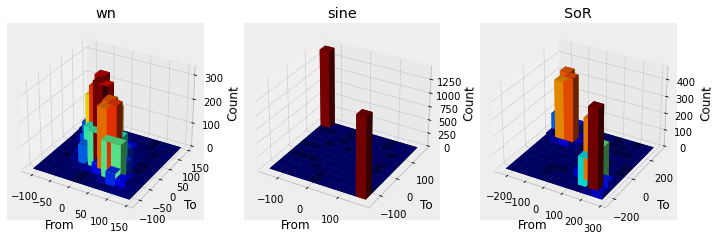

In [3]:
# read the rf data
rf_dict = pickle.load(open("rf_dict.p", "rb"))
f = plot_rf(rf_dict)

### Meanstress transformation ###

In [4]:
meanstress_sensitivity = pd.Series({
    'M': 0.3,
    'M2': 0.2
})

In [5]:
transformed_dict = {k: rf_act.meanstress_hist.FKM_goodman(meanstress_sensitivity, R_goal=-1.) for k, rf_act in rf_dict.items()}

In [6]:
transformed_dict

{'wn': range
 (0.0, 26.477329977321546]                   1260
 (26.477329977321546, 52.95465995464309]      970
 (52.95465995464309, 79.43198993196464]       718
 (79.43198993196464, 105.90931990928618]      682
 (105.90931990928618, 132.38664988660773]     322
 (132.38664988660773, 158.86397986392927]     280
 (158.86397986392927, 185.34130984125082]      76
 (185.34130984125082, 211.81863981857236]      52
 (211.81863981857236, 238.2959697958939]       18
 Name: frequency, dtype: int32,
 'sine': range
 (0.0, 31.995866105205906]                      0
 (31.995866105205906, 63.99173221041181]        1
 (63.99173221041181, 95.98759831561772]         0
 (95.98759831561772, 127.98346442082362]        0
 (127.98346442082362, 159.9793305260295]        0
 (159.9793305260295, 191.97519663123543]        0
 (191.97519663123543, 223.97106273644135]       0
 (223.97106273644135, 255.96692884164725]       0
 (255.96692884164725, 287.96279494685314]    2901
 Name: frequency, dtype: int32,
 'SoR': 

## Repeating factor

In [79]:
repeating = {
    'wn': 50.0, 
    'sine': 25.0,
    'SoR': 1
}

In [80]:
load_dict = {k: transformed_dict[k] * repeating[k] for k in repeating.keys()}

We are calculating a seperat load case, where we summarize the three channels together. Later on we can compare the damage results of this channel with the sum of the other channels

In [81]:
load_dict['total'] = combine_hist([load_dict[k] for k in load_dict.keys()], method="sum", nbins=9, histtype="range")

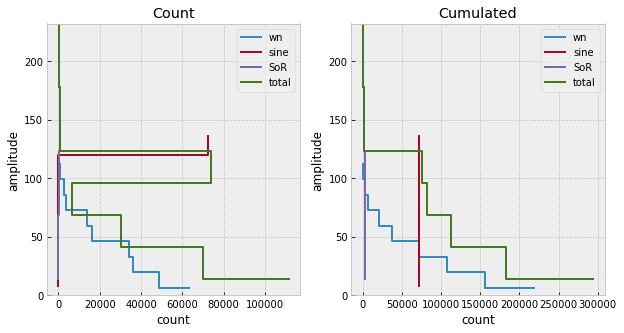

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

for k, v in load_dict.items():
    amplitude = v.rainflow.amplitude[::-1]
    cycles = v.values[::-1].ravel()
    ax[0].step(cycles, amplitude, label=k)
    ax[1].step(np.cumsum(cycles), amplitude, label=k)

for title, ai in zip(['Count', 'Cumulated'], ax):
    ai.set_title(title)
    ai.xaxis.grid(True)
    ai.legend()
    ai.set_xlabel('count')
    ai.set_ylabel('amplitude')
    ai.set_ylim((0,max(amplitude)))  

## Nominal stress approach ##

### Material parameters ###
You can create your own material data from Woeler tests using the Notebook woehler_analyzer

In [83]:
mat = pd.Series({
    'k_1': 8.,
    'ND': 1.0e6,
    'SD': 300.0,
    'TN': 1./12.,
    'TS': 1./1.1
})
display(mat)

k_1          8.000000
ND     1000000.000000
SD         300.000000
TN           0.083333
TS           0.909091
dtype: float64

### Damage Calculation ###

In [86]:
# damage for every load range
damage_miner_original = {k: mat.fatigue.damage(v.rainflow) for k, v in load_dict.items()}
damage_miner_elementary = {k: mat.fatigue.miner_elementary().damage(v.rainflow) for k, v in load_dict.items()}
damage_miner_haibach = {k: mat.fatigue.miner_haibach().damage(v.rainflow) for k, v in load_dict.items()}

# and the damage sum
damage_sum_miner_haibach = {k: v.sum() for k, v in damage_miner_haibach.items()}
# ... and so on
print(damage_sum_miner_haibach)

print("total from sum: " + str(damage_sum_miner_haibach["wn"] + damage_sum_miner_haibach["sine"] + damage_sum_miner_haibach["SoR"]))

{'wn': 5.679533543092547e-10, 'sine': 5.080552318638052e-07, 'SoR': 4.81888283139527e-06, 'total': 4.932782564068097e-06}
total from sum: 5.327506016613385e-06


If we compare the sum of the first three load channels with the 'total' one. The different is based on the fact that we have used 10 bin only. Try to rerun the notebook with a higher bin resolution and you will see the differences.

[]

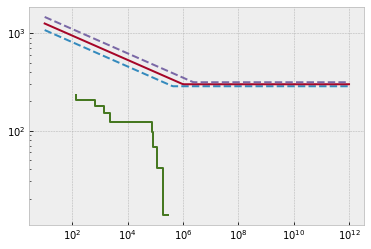

In [88]:
wc = mat.woehler
cyc = pd.Series(np.logspace(1, 12, 200))
for pf, style in zip([0.1, 0.5, 0.9], ['--', '-', '--']):
    load = wc.basquin_load(cyc, failure_probability=pf)
    plt.plot(cyc, load, style)

plt.step(np.cumsum(cycles), load_dict['total'].rainflow.amplitude[::-1])

plt.loglog()

## Failure Probaility ##

#### Without field scatter ####

In [ ]:
D50 = 0.05

damage = mat.fatigue.damage(transformed['total'].rainflow).sum()

di = np.logspace(np.log10(1e-2*damage), np.log10(1e4*damage), 1000)
std = pylife.utils.functions.scatteringRange2std(mat.TN)
failprob = fp.FailureProbability(D50, std).pf_simple_load(di)

fig, ax = plt.subplots()
ax.semilogx(di, failprob, label='cdf')

plt.xlabel("Damage")
plt.ylabel("cdf")
plt.title("Failure probability = %.2e" %fp.FailureProbability(D50,std).pf_simple_load(damage))  
plt.ylim(0,max(failprob))
plt.xlim(min(di), max(di))

fp.FailureProbability(D50, std).pf_simple_load(damage)

#### With field scatter ####

In [ ]:
field_std = 0.35
fig, ax = plt.subplots()
# plot pdf of material
mat_pdf = norm.pdf(np.log10(di), loc=np.log10(D50), scale=std)
ax.semilogx(di, mat_pdf, label='pdf_mat')
# plot pdf of load
field_pdf = norm.pdf(np.log10(di), loc=np.log10(damage), scale=field_std)
ax.semilogx(di, field_pdf, label='pdf_load',color = 'r')
plt.xlabel("Damage")
plt.ylabel("pdf")
plt.title("Failure probability = %.2e" %fp.FailureProbability(D50, std).pf_norm_load(damage, field_std))  
plt.legend()

## Local stress approach ##
#### FE based failure probability calculation

#### FE Data

In [ ]:
vm_mesh = pylife.vmap.VMAPImport("plate_with_hole.vmap")
pyLife_mesh = (vm_mesh.make_mesh('1', 'STATE-2')
               .join_coordinates()
               .join_variable('STRESS_CAUCHY')
               .to_frame())


In [ ]:
mises = pyLife_mesh.groupby('element_id')['S11', 'S22', 'S33', 'S12', 'S13', 'S23'].mean().equistress.mises()
mises /= 200.0  # the nominal load level in the FEM analysis
#mises

#### Damage Calculation ####

In [ ]:
scaled_rainflow = transformed['total'].rainflow.scale(mises)
#scaled_rainflow.amplitude, scaled_rainflow.frequency

In [ ]:
damage = mat.fatigue.damage(scaled_rainflow)
#damage


In [ ]:
damage = damage.groupby(['element_id']).sum()
#damage

In [ ]:
#pyLife_mesh = pyLife_mesh.join(damage)
#display(pyLife_mesh)

In [ ]:
grid = pv.UnstructuredGrid(*pyLife_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=damage.to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()

In [ ]:
print("Maximal damage sum: %f" % damage.max())